In [1]:
import tensorflow as tf
import numpy as np
import os
import pathlib
import time
import datetime
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from IPython import display
import torch

# Generativni modeli

Generativni modeli modeluju zajedničku raspodelu promenljivih **p(x)**. Modelovanje zajedničke raspodele obično zahteva veću količinu podataka, podložnije je prokletsvu dimenzijonalnosti i dodatnih problema. S druge strane prednosti su što zajednička raspodela nosi potpunu informaciju o podacima i omogućava predviđanje nekih promenljivih na osnovu drugih.

U slučaju podataka kao što su slike, problem dimenzionalnosti je drastično izražen. Stoga, moderni gerativni modeli poput generativnih suparničkih mreža i varioionih autoenkodera funkcionišu na drugom principu. Oni direktno modeluju preslikavanje iz nekog niskodimenzionalnog prostora u kojem se vrši uzorkovanje u jednostavnim modtodama u visokodimenzionalni prostor podataka, tako da vrenosti funkcije imaju željenu zajedničku raspodelu. Ovo drastično popravlja računarske performanse u vreme generisanja, ali može značajno da oteža obučavanje i matematički zakomplikovati modele i algoritme.

## Generativne suparničke mreže

Generativne suparničke mreže ili GAN-ovi (eng. <em>generative adversarial networks</em>) zasnivaju se na najzanimljivoj ideji obučavanja. T ideja je posebno problematična za pouzdano i stabilno obučavanje, ali daje odlične rezultate ako uspe.
Osnovna ideja je da imamo dva modela-<em> generator </em> koji generiše podatke i <em> diskriminator </em> koji kalsifikuje slike u prave i generisane. Diskriminator se obučava tako da što bolje razlikuje generisane slike od pravih, dok se generator obučava da što bolje generiše slike koje diskriminator neće razlikovati od pravih. Kako se generator menja, tako se menja i diskriminator i obrnuto, tako se ova dva modela naizmenično obučavaju.
Generator transformiše neki latenti prostor odabrane dimenzije u sliku određene rezolucije. Ovakva arhitektura korišćena je u modelu DCGAN koja će biti nakadno pokazana. Generator implicitno definiše raspodelu podataka, i poželjno je da ta raspodela bude što približnija pravoj.


<img src="images/generatorDCGAN.png"  width="600" hight="600" align="left">




Funkcija greške može se posmatrati kao igra gde prvi igrač želi da poveća svoju dobit, dok drugi igrač želi da smanji maksimalnu dobit prvog igrača. Generator se bira tako da maksimiyuje grešku najboljeg diskriminatora- onog sa minimalnom greškom za dati generator.  Grešku diskriminatora možemo formulisati kao: 

<img src="images/greska-diskriminator.png"  width="600" hight="600" align="left">  <br><br><br><br>


Smisao prvog dela je da diskriminator mora da ti vrenost blisku 1 pravim slikama, dok je smisao drugog dela da diskriminator slikama koje je generisao generator da vrednost blisku 0.<br> Ako je D(G(z)) vrednost bliska 0, onda je 1 - D(G(z)) je vrednost bliska 1 pa je greška mala. U suprotnom, ako je D(G(z)) blizu 1, greška bi bila velika, 
Ova greška izražava dobre kvalitete diskriminatora, pa je problem koji želimo da rešimo:

<img src="images/diskriminator-problem.png"  width="900" hight="600" align="left">

Promene diskriminator i generatora u procesu obučvanja ilustrovane su sledećom slikom:
<img src="images/generator-diskriminator.png"  width="1000" hight="700" align="left"> <br><br><br><br><br><br>



-  u prvoj fazi oučavanja generator G ne aproksimira dobro raspodelu i diskriminator D loše razlikuje generisane i prave podatke
-  diskriminator je naučio da razlikuje prave i generisane podatke
-  generator je naučio bolje da aproksimira raspodelu podataka
-  generator je naučio da aproksimira raspodelu podataka, a diskriminator ne može da razlikuje stvarne i generisane podatke. Ovo se dešava kada je generisana raspodela odgovara raspodeli ciljanih podataka. U ovom slučaju ni diskriminator ni generator ne mogu da napreduju.

## Uslovljene generativne suparničke mreže 

Obične generativne suparničke mreže generišu sliku samo na osnovu šuma z, tj vrše preskikavanje G:z->y, dok uslovljene generativne suparničke mreže vrše preslikavanje G:x,z->y. Naime uslovljene genrativne suparničkre mreže, ili skraćeno cGAN, uzimaju u obzir i ulaz x. I dalje je potrebnoda se na ulaz dodaje neka vrsta šuma. Namime, model bi mogao da radi i bez dodavanja šuma, al u tom slučaju model nije nederministički i nije u mogućnosti da modeluje raspodelu.


<img src="images/cgan.png"  width="600" hight="600" align="left"> <br><br><br><br><br><br><br><br><br><br>


-  generator na osnovu ulaza x generiše sliku
-  generisana slika i ulaz x predstavljaju argumente za diskriminator koji odulučuje da li se radi o pravoj slici
-  analogno prethodnom se radi samo što se generisane slike prosledi z

In [2]:
import tensorflow as tf
import numpy as np
import os
import pathlib
import time
import datetime
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from IPython import display
import torch

Koristi se fashion_mnist skup podataka zbog jednostavnosti. Koristiće se arhitektura DCGAN modela da bi se pokazao rad GAN na ovom skupu podataka.

In [3]:
(train_images,_), (_,_) = tf.keras.datasets.fashion_mnist.load_data()

In [4]:
# Proveravanje ispravnosti ucitanog testa

In [5]:
assert train_images.shape == (60000, 28, 28)

In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalizovanje slika u opseg [-1, 1]

Postavljanje  veličine bufera i veličine podskupa za treniranje.

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [8]:
# Učitiavanje podatak i nasumično mešanje
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Arhitektura DCGAN
<img src="images/DCGANarh.png"  width="1000" hight="700" align="left"> <br><br><br><br><br><br>

In [9]:
def Generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256,use_bias=False,input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7,7,256)))
    
    model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())  
    
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    return model

Generator uzima podatke iz latentnog prostora dimenzije 100 i pokušava da ga transofrmiše ciljani skupa podataka.

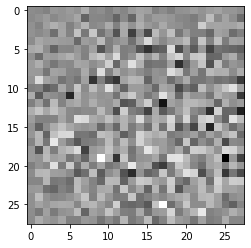

In [10]:
generator = Generator()
random_image = tf.random.normal([1,100])
generated_image = generator(random_image)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

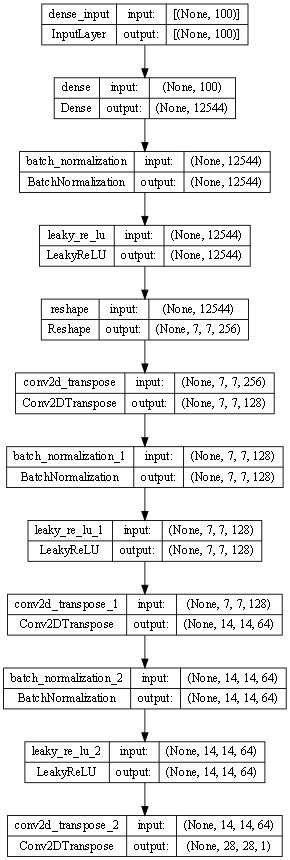

In [11]:
tf.keras.utils.plot_model(generator,to_file="./models/01-dcgan/generator.png",show_shapes=True,dpi=64)

In [12]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [13]:
def Discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[28, 28, 1]))
    
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [14]:
discriminator = Discriminator()
decision = discriminator(generated_image)


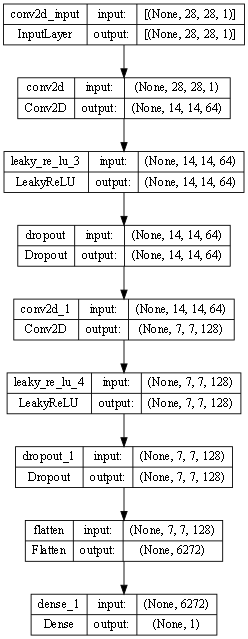

In [15]:
tf.keras.utils.plot_model(discriminator,to_file="./models/01-dcgan/diskriminator.png",show_shapes=True,dpi=64)

In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Funkcija gubitka diskriminatora upoređuje  predikciju diskriminatora od prave slike sa nizom jedinica, dok za generisanu sliku uporedjuje predikciju i niza nula. Naime, želja je da predikcija prave slike bude što približnija nizu jedinica pa da se tako obučva diskriminator da raspoznaje prave slike. Sa generisanim slikama situacija je suprotna. Želimo da predikcija bude što sličnija nizu nula.

In [17]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


Pošto je želja generatora da što bolje prevari diskriminatora, njegova greška se sastoji od uporedjivanje generisane slike i niza jedinica. Vidimo da se ovde koristi niz jedinica dok se za generisanu sliku kod funkcije gubitka generatora koristilo niz nula za generisanu sliku. Razlog tome je što generator želi da predikcija generisane slike bude što bliža nizu jedinica dok diskriminator želi da bude što bliža nizu nula.

In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [20]:
checkpoint_dir = './checkpoints/01-dcgan/train'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [21]:
EPOCHS = 150
noise_dim = 100
num_examples_to_generate = 16

generator_losses = list()
discriminator_losses = list()
# Pamtimo seed da bismo mogli prilikom ponavljanja eksprimenta da dobijemo iste rezultate
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [22]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)


    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [23]:
def train(dataset, epochs, save_img= False ):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            gan_loss , disc_loss =train_step(image_batch)


        generator_losses.append(gan_loss)
        discriminator_losses.append(disc_loss)
    
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Cuvamo model na svakih 15 epoha
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Vreme potrebno za epohu {} je {} sekunda'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed, save_img)

In [24]:
def generate_and_save_images(model, epoch, test_input, save_image=False):

    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    if save_image:
        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

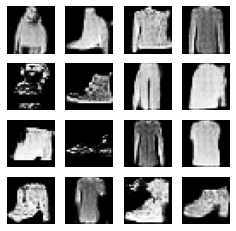

In [25]:
# promenom poslednjeg argumenta na True posle svake epohe slika ce biti sačuvana u direktorijum gde se nalazi jupyter sveska
train(train_dataset, EPOCHS,False)

In [26]:
len(generator_losses)

150

Sad ćemo prikazati grafike gubitaka za generator i disrkiminator

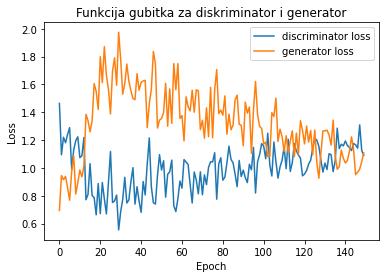

In [27]:
plt.title('Funkcija gubitka za diskriminator i generator')
plt.plot(range(0,len(discriminator_losses)), discriminator_losses, label='discriminator loss')
plt.plot(range(0,len(generator_losses)), generator_losses, label='generator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.show()

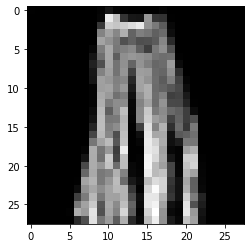

In [28]:

generated_image = generator(random_image)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [29]:
generator.save('models/01-dcgan/generator.h5')
discriminator.save('models/01-dcgan/discriminator.h5')

In [30]:
generator_loaded = tf.keras.models.load_model('models/01-dcgan/generator.h5')

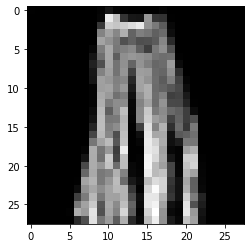

In [31]:
generated_image = generator_loaded(random_image)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')